In [22]:
import datasets
import transformers
import torch
import torch.nn as nn
from tqdm import tqdm
device = torch.device("mps")

In [2]:
from datasets import load_dataset
emotions = load_dataset("emotion")

In [3]:
emotions

DatasetDict({
    train: Dataset({
        features: ['text', 'label'],
        num_rows: 16000
    })
    validation: Dataset({
        features: ['text', 'label'],
        num_rows: 2000
    })
    test: Dataset({
        features: ['text', 'label'],
        num_rows: 2000
    })
})

In [4]:
train_ds = emotions["train"]
val_ds = emotions["validation"]
test_ds = emotions["test"]

In [5]:
#convert into df
emotions.set_format(type="pandas")

In [6]:
df = emotions['train'][:]

In [7]:
df

,text,label
0,i didnt feel humiliated,0
1,i can go from feeling so hopeless to so damned...,0
2,im grabbing a minute to post i feel greedy wrong,3
3,i am ever feeling nostalgic about the fireplac...,2
4,i am feeling grouchy,3
...,...,...
15995,i just had a very brief time in the beanbag an...,0
15996,i am now turning and i feel pathetic that i am...,0
15997,i feel strong and good overall,1
15998,i feel like this was such a rude comment and i...,3


In [8]:
def int2str(row):
    return emotions['train'].features['label'].int2str(row)

In [9]:
df['emotion'] = df['label'].apply(int2str)

In [10]:
df

,text,label,emotion
0,i didnt feel humiliated,0,sadness
1,i can go from feeling so hopeless to so damned...,0,sadness
2,im grabbing a minute to post i feel greedy wrong,3,anger
3,i am ever feeling nostalgic about the fireplac...,2,love
4,i am feeling grouchy,3,anger
...,...,...,...
15995,i just had a very brief time in the beanbag an...,0,sadness
15996,i am now turning and i feel pathetic that i am...,0,sadness
15997,i feel strong and good overall,1,joy
15998,i feel like this was such a rude comment and i...,3,anger


<Axes: xlabel='emotion', ylabel='count'>

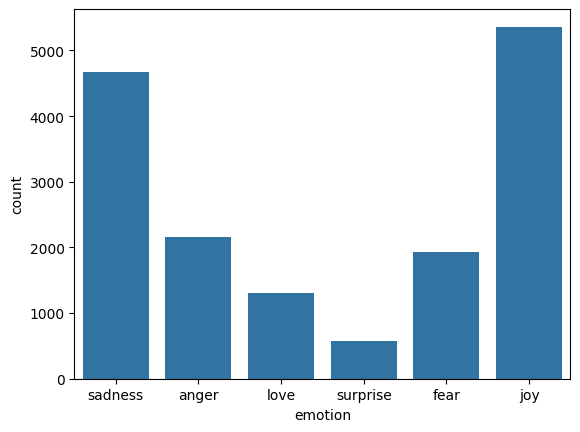

In [11]:
import seaborn as sns
sns.countplot(x='emotion',data=df)

In [12]:
emotions.reset_format()

In [13]:
#load bert tokenizer
from transformers import AutoTokenizer
model_ckpt = "distilbert-base-uncased"
tokenizer = AutoTokenizer.from_pretrained(model_ckpt)

In [14]:
enc_text = tokenizer("The Transformer network was mesmerized by the sheer complexity of the text")

In [15]:
tokens = tokenizer.convert_ids_to_tokens(enc_text.input_ids)

In [16]:
tokens

['[CLS]',
 'the',
 'transform',
 '##er',
 'network',
 'was',
 'me',
 '##sm',
 '##eri',
 '##zed',
 'by',
 'the',
 'sheer',
 'complexity',
 'of',
 'the',
 'text',
 '[SEP]']

In [17]:
# "##"-> Means attach to previous token
tokenizer.vocab_size
tokenizer.max_len_single_sentence

510

In [38]:
text = "sample text"
inputs = tokenizer(text,return_tensors="pt")

In [51]:
def tokenize(batch):
    tokenizer(batch['text'],padding=True,truncation=True)

In [52]:
emotions_encoded = emotions.map(tokenize,batched=True,batch_size=None)

Map:   0%|          | 0/16000 [00:00<?, ? examples/s]

Map:   0%|          | 0/2000 [00:00<?, ? examples/s]

Map:   0%|          | 0/2000 [00:00<?, ? examples/s]

In [40]:
inputs = {k:v.to(device) for k,v in inputs.items()}

In [41]:
from transformers import AutoModel
model = AutoModel.from_pretrained(model_ckpt).to(device)

In [47]:
with torch.no_grad():
    outputs = model(**inputs)

In [48]:
#access last hidden state
outputs.last_hidden_state.shape
# it has given 768 dim vector for 2 tokens in sentence as well as [CLS] and [SEP]

torch.Size([1, 4, 768])

In [49]:
#for classification we only need hidden state associated with [CLS]
last_h = outputs.last_hidden_state[:,0]

### This can be done now for whole dataset

In [ ]:
def extract_hidden_states(batch):
    inputs = {k:v.to(device) for k,v in batch if k in model.}
    last_hidden = model(**inputs).last_hidden_state[:,0]
    return last_hidden